# Large scale text analysis with deep learning (3 points)

In this assignment, you will develop a deep learning model to predict salaries based on resumes (credits to to [Oleg Vasilev](https://github.com/Omrigan/)). While we will begin this project during our seminar class, it will require additional effort on your part to finalize and submit it as homework.

Following this, there is a supplementary task in another notebook titled homework_part2.ipynb. In this task, you are expected to conduct a more extensive study. This will involve testing various architectures to optimize prediction accuracy.

To secure full marks for this assignment, ensure a consistent training process with an MSE loss falling below 0.10. If necessary, feel free to experiment with different parameters and model architectures. If you achieve the desired results in the homework_part2.ipynb, you can either replicate your solution here or reference it explicitly in the comments when you submit.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from 
1) Yandex-disk [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7), or
2) the Kaggle ompetition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data.shape

(244768, 12)

In [3]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

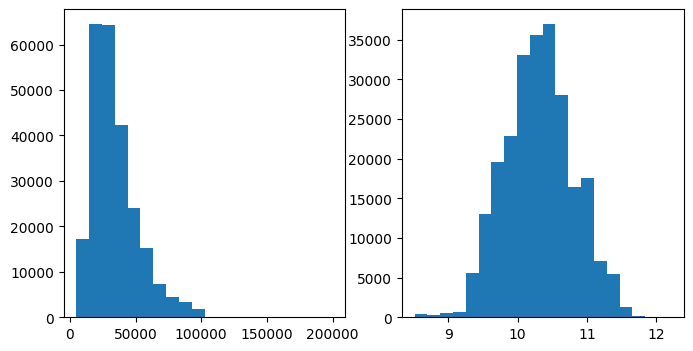

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
193267,71765264,Weekend Chef,City and Guilds/NVQ or equivalent. Food hygien...,Milton Keynes,Milton Keynes,full_time,NaN,Brain Injury Rehabilitation Trust,Hospitality & Catering Jobs,8.91 - 8.91 per hour,17107,Jobcentre Plus,9.747301
17127,66913278,NonFunctional QA Consultant Permanent Docklands,"NonFunctional QA Consultant LoadRunner, Visual...",East London London South East,South East London,NaN,permanent,Blue Personnel,IT Jobs,"From 50,000 to 70,000 per annum",60000,cwjobs.co.uk,11.002116
96441,69249844,Lead Mechanical Engineer,Lead Mechanical Engineer **** **** Pension (...,Oxford,Oxford,NaN,permanent,Future Engineering Recruitment Ltd,Engineering Jobs,50k - 60k pa + Package,55000,jobsite.co.uk,10.915107


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [6]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [7]:
data[text_columns]

,Title,FullDescription
0,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...
1,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...
2,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...
3,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...
4,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do..."
...,...,...
244763,TEACHER OF SCIENCE,Position: Qualified Teacher Subject/Specialism...
244764,TEACHER OF BUSINESS STUDIES AND ICT,Position: Qualified Teacher or NQT Subject/Spe...
244765,ENGLISH TEACHER,Position: Qualified Teacher Subject/Specialism...
244766,SUPPLY TEACHERS,Position: Qualified Teacher Subject/Specialism...


In [8]:
import nltk
#

tokenizer = nltk.tokenize.WordPunctTokenizer()

In [9]:
str(None)

'None'

In [9]:
def join_token(s : str) -> str:
    s = str(s)
    return ' '.join(tokenizer.tokenize(s)).lower()

In [10]:
data[text_columns] = data[text_columns].map(lambda x: join_token(x))

In [11]:
data["FullDescription"][2][:50]

'mathematical modeller / simulation analyst / opera'

Now we can assume that our text is a space-separated list of tokens:

In [12]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [13]:
data['Title'].values.tolist()

['engineering systems analyst',
 'stress engineer glasgow',
 'modelling and simulation analyst',
 'engineering systems analyst / mathematical modeller',
 'pioneer , miser engineering systems analyst',
 'engineering systems analyst water industry',
 'senior subsea pipeline integrity engineer',
 'recruitment consultant industrial / commercial / engineering / driv',
 'recruitment consultant construction / technical / trades labour',
 'subsea cables engineer',
 'trainee mortgage advisor east midlands',
 'project engineer , pharmaceutical',
 'principal composite stress engineer',
 'senior fatigue damage tolerance engineer',
 'chef de partie award winning restaurant excellent tips',
 'quality engineer',
 'principal controls engineer',
 'chef de partie award winning dining live in share of tips',
 'senior fatigue and damage tolerance engineer',
 'c i design engineer',
 'lead engineers ( stress )',
 'relief chef de partie croydon , surrey live in',
 'senior control and instrumentation engineer

In [14]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total
for col in text_columns:
    for val in data[col].values:
        token_counts.update(val.split())

In [ ]:
# token_counts.most_common(1)

[('business development manager', 960)]

In [15]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


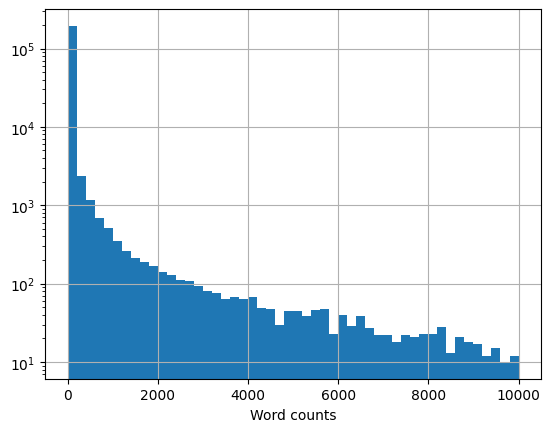

In [17]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");
plt.grid()
# plt.plot(y);

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [18]:
list(token_counts.items())[:5]

[('engineering', 68563),
 ('systems', 77071),
 ('analyst', 34427),
 ('stress', 1855),
 ('engineer', 94623)]

In [19]:
token_counts['me']

12344

In [20]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = list(filter(lambda x : token_counts[x] >= min_count, list(token_counts.keys())))

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [21]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [22]:
token_to_id = {tokens[i] : i for i in range(len(tokens))}

In [23]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [24]:
data['Title'].head()

0                          engineering systems analyst
1                              stress engineer glasgow
2                     modelling and simulation analyst
3    engineering systems analyst / mathematical mod...
4          pioneer , miser engineering systems analyst
Name: Title, dtype: object

In [26]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [27]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [28]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

,dtype,<class 'numpy.float32'>
,separator,'='
,sparse,False
,sort,True


### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [30]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [31]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision.transforms import v2

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

In [ ]:
transform_text = v2.Compose(
    [
        v2.ToTensor(),
        v2.ToDtype(dtype=torch.int64)
    ]
)
transform = v2.Compose(
    [
        v2.ToTensor()
    ]
)

In [ ]:
class text_dataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self):


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [34]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[   18,   287,   359,     1,     1,     1,     1],
         [ 2863,    11,    12,    13,    55,    37, 12109],
         [ 2833,   618,   858,    63,  7104,  7105,    64]], device='cuda:0'),
 'FullDescription': tensor([[   18,   287,   359,  1408,   561,    18,   287,   359,  1464,  1408],
         [ 2863,    11,    12,    13,    55,    37, 12109,  1767,  1166,    74],
         [  142,  1617,  8830,  1314,  1464,   559,   560,   561,   618,   858]],
        device='cuda:0'),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144], device='cuda:0')}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

In [42]:
batch = make_batch(data_train[:100], device=device)
batch['Title']

tensor([[  18,  287,  359,  ...,    1,    1,    1],
        [2863,   11,   12,  ...,    1,    1,    1],
        [2833,  618,  858,  ...,    1,    1,    1],
        ...,
        [  70,  120,    6,  ...,    1,    1,    1],
        [  22,   23,    1,  ...,    1,    1,    1],
        [  18,  873, 1661,  ...,    1,    1,    1]], device='cuda:0')

In [83]:
class title_encoder(nn.Module):
    def __init__(self, n_tokens, dim_emb=5):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=dim_emb)

        self.model = nn.Sequential(
                nn.Conv1d(dim_emb, dim_emb*3, kernel_size=5, padding=2),
                nn.ReLU(True),
                nn.Conv1d(dim_emb*3, dim_emb*6, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.AdaptiveAvgPool1d(1)
        )


    def forward(self, x):
        x = self.emb(x)
        x = x.permute(0, 2, 1)
        x = self.model(x)
        x = x.squeeze(2)
        return x


In [89]:
categorical_columns[0]

'Category'

In [91]:
bat = batch
# md = title_encoder(n_tokens=len(tokens), dim_emb=5).to(device)

In [97]:
bat.keys()

dict_keys(['Title', 'FullDescription', 'Categorical', 'Log1pSalary'])

In [86]:
x_hat = md(bat)
x_hat.shape

torch.Size([100, 30])

In [101]:
class description_encoder(nn.Module):
    def __init__(self, n_tokens, dim_emb=5):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=dim_emb)

        self.model = nn.Sequential(
                nn.Conv1d(dim_emb, dim_emb*3, kernel_size=5, padding=2),
                nn.ReLU(True),
                nn.Conv1d(dim_emb*3, dim_emb*6, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.AdaptiveAvgPool1d(1)
        )


    def forward(self, x):
        x = self.emb(x)
        x = x.permute(0, 2, 1)
        x = self.model(x)
        x = x.squeeze(2)
        return x


In [102]:
class categorical_encoder(nn.Module):
    def __init__(self, n_cat_features, cat_hid, hid_con, dim_emb=5):
        super().__init__()
        # self.emb = nn.Embedding(num_embeddings=n_cat_features, embedding_dim=dim_emb)

        self.model = nn.Sequential(
            nn.Linear(n_cat_features, out_features=cat_hid),
            nn.ReLU(True),
            nn.Linear(cat_hid, hid_con)
        )


    def forward(self, x):
        return self.model(x)


In [125]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), cat_hid=32, hid_con = 30, hid_size=64):
        super().__init__()
        self.de = description_encoder(n_tokens=n_tokens)
        self.te = title_encoder(n_tokens=n_tokens)
        self.ce = categorical_encoder(n_cat_features, cat_hid, hid_con)
        self.relu = nn.ReLU(True)
        self.lin = nn.Linear(hid_con*3, hid_size)
        self.lin2 = nn.Linear(hid_size, 1)


    def forward(self, batch):
        x, y , z = self.de(batch['FullDescription']), self.te(batch['Title']), self.ce(batch['Categorical'])
        x = torch.concat([x, y, z], dim=1)
        x = self.relu(x)
        x = self.lin2(self.lin(x))
        x = torch.squeeze(x, dim=1)
        return x


        # YOUR CODE HERE


In [126]:
model = SalaryPredictor().to(device)

In [127]:
x = model(batch)
# q = torch.concat([x, y, z], dim=1)

In [128]:
x.shape

torch.Size([100])

In [129]:
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100], device=device)
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [130]:
def iterate_minibatches(data, batch_size=32, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [131]:
from tqdm.auto import tqdm

BATCH_SIZE = 32
EPOCHS = 10

In [133]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


In [134]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_metrics(model, data_val, device=device)


epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.13972
Mean absolute error: 0.29063
epoch: 1


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.12077
Mean absolute error: 0.26656
epoch: 2


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10838
Mean absolute error: 0.25019
epoch: 3


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.10262
Mean absolute error: 0.24384
epoch: 4


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09963
Mean absolute error: 0.23985
epoch: 5


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.09153
Mean absolute error: 0.22735
epoch: 6


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08865
Mean absolute error: 0.22355
epoch: 7


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08700
Mean absolute error: 0.22081
epoch: 8


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08421
Mean absolute error: 0.21725
epoch: 9


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.08834
Mean absolute error: 0.22305


### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [135]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens))

    *predictions_drop_one_token, baseline_pred = model(make_batch(data_drop_one_token, device=device)).detach().cpu()
    diffs = baseline_pred - torch.Tensor(predictions_drop_one_token)
    return list(zip(sample_col_tokens, diffs))

In [136]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):

    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]

    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]


    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))

    return raw_html


In [137]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [138]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

cleaning operative

12 . 5 hours per week monday friday 9am 11 . 30am duties to include sweeping , mopping , vacuuming , buffing , cleaning staff toilets and rest room . must be able to read as they will be using UNK which need UNK as per instructions on the containers . sucessfull applicants will be trained on all electrical appliances and UNK of cleaning materials .

In [139]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 160707
Salary (gbp): tensor([32371.5156])


UNK uk limited sales and marketing director

UNK uk limited sales and marketing director closing date : 27th february 2013 about us : UNK is the world ’ s leading multichannel agency network . we ’ re a new kind of agency ; one which powers profitable customer experiences that change how people think , act and feel about brands . the experiences we create utilise traditional , digital , social and mobile media as well as new technologies and invented media . they are the product of our creativity and 45 years of expertise in data , analytics , strategy , user experience , media and technology . UNK is a fullservice , integrated agency with 52 offices in 48 countries . our creative solutions span above , below and through the line channels we ’ re online , offline , retail , pharma , financial , fundraising , fmcg and travel . we ’ re awardwinning innovators who are trusted over decades by our clients and we have a proven trackrecord . UNK ’ s heritage is in direct marketing and we are still one of the largest and most successful dm agencies in the world . we understand that today ’ s marketing challenges require agencies to think differently , to think openly and creatively to solve different kinds of problems in different ways . the common theme running throughout UNK ’ s approach in all offices and throughout all teams ( and the source of our competitive advantage ) is the use of data and insights – collectively to solve these complex challenges we work with some of the biggest and most interesting clients around across a variety of industry sectors – virgin media , pfizer , UNK , barclaycard , UNK , UNK ( UNK ), guide dogs , dixons , nspcc and cancer research to name but a few . we have plenty of new clients we ’ re hoping to work with soon too , so now is a very exciting time to think about working with us . role overview : the role of the sales and marketing director is it to maintain a healthy new business pipeline and improve our conversion rates within UNK – across both our london and east grinstead offices and on a global scale . a ‘ healthy pipeline ’ is regarded as one where there are genuine opportunities on the horizon in the short ( 3 months ), medium ( 48 months ) and long (**** month ) term . ultimately it is the role of the sales and marketing director to prospect , pitch and train so that a sales culture can be developed within the organisation and healthy growth can be achieved . you will also be expected to assist in marketing initiatives where required and your involvement on retention of existing clients will be paramount . core criteria for this position : global experience within business development with particular emphasis on exposure and understanding of the us market significant understanding of leading client relationships at a senior level , ideally from a managing partner or senior client director position experience from within a similar agency environment , ideally spanning outside of the emea region you will be tasked with instilling a competitive culture within the business and team so experience of team management and reporting into boardlevel is essential . core company benefits included : 23 days holiday , rising to 25 days after two years and 30 days after 5 years ’ service . flexible benefits , l UNK assurance , season ticket loan , birthday ’ s off and learning development opportunities this job was originally posted as www . totaljobs . com / jobseeking / UNK ****

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)